# Experiment: Comparison to the conventional estimation of 3D LUTs
This Experiment aims to compare the CNN generated 3D LUT to a 3D LUT based on conventional calculations to see the accuracy and speed of AI in the computationally expensive task of estimating LUTs.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
from torchinfo import summary
from pytorch_msssim import ssim, ms_ssim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [3]:
batch_size = 64
lut_size = 33
learning_rate = 1e-3
num_epochs = 500
experiment = "fuji_w_interpolation"
model_name = "img2lut_fuji_w_interpolation.pth.tar"

# Dataset
The Dataset for this Experiment consists of paired Images that are *ungraded* RAW images and *graded* JPG Images from a Fujifilm X100 F camera.

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [5]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

The function `load_images_from_directory` gets all images that are within a specific directory, converts them into RGB and can apply a transformation to the images. Additionally the number of images that are processed can be limited with the `num_images` parameter. The function returns a tensor of images. The tensor has the shape (number of images x width x height x channels). 

In [7]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

# Replace fake images with actual data from the directory
ungraded_images = load_images_from_directory('../../fuji_images/RAW/JPG/256x256', num_images=600)
graded_images = load_images_from_directory('../../fuji_images/JPG/256x256', num_images=600)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([66, 256, 256, 3])
torch.Size([66, 256, 256, 3])


As we can see above, for this experiment we use 68 images.

In [8]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualization of the Dataset

In [9]:
# Function to plot a set of images in a 8x8 grid
def plot_image_grid(images, title):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

## Ungraded training Images
The following Image Grid shows the ungraded training images:

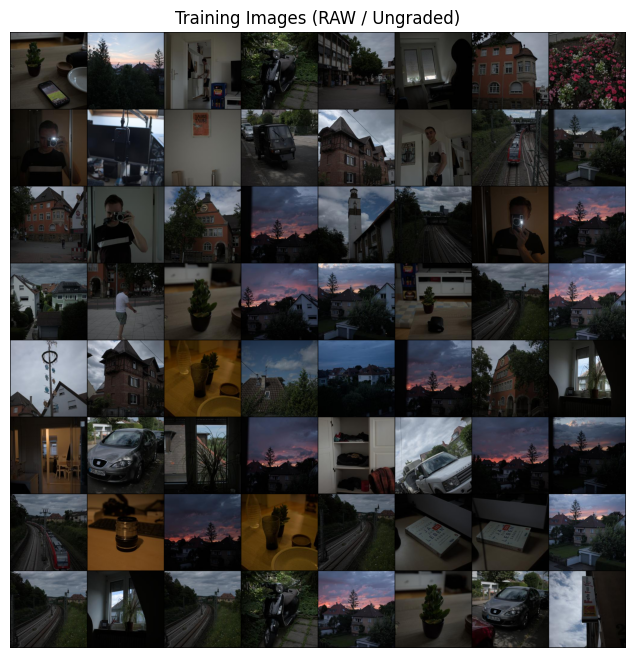

In [10]:
ungraded, graded = next(iter(dataloader))

plot_image_grid(ungraded, "Training Images (RAW / Ungraded)")

## Graded training Images
The following Image Grid shows the graded training images:

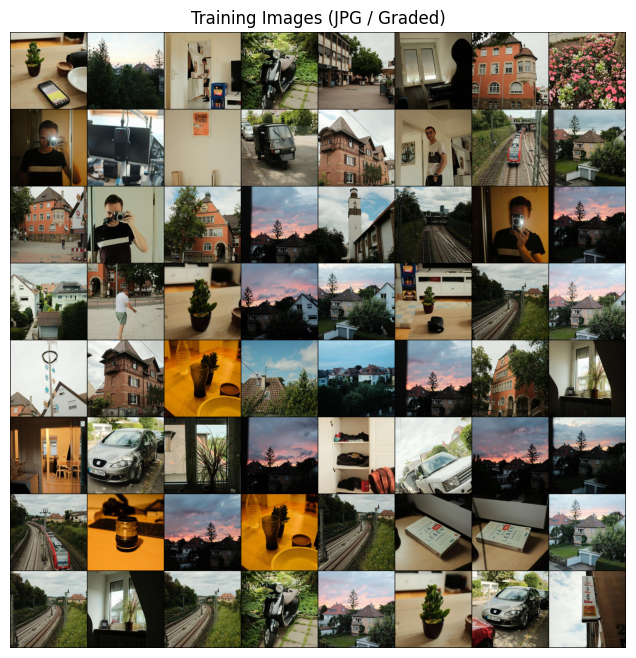

In [11]:
plot_image_grid(graded, "Training Images (JPG / Graded)")

# Apply LUT function

In [12]:
def trilinear_interpolation(luts, images):
    batch_size, channels, height, width = images.shape
    lut_size = luts.shape[1]
    
    # Normalize input images to [0, 1] range
    normalized_images = (images - images.min()) / (images.max() - images.min())
    
    # Create coordinate grid for interpolation
    grid_x = normalized_images * (lut_size - 1)
    
    # Compute interpolation coordinates
    x0 = grid_x.floor().long()
    x1 = (x0 + 1).clamp(max=lut_size - 1)
    
    # Compute interpolation weights
    wx = grid_x - x0.float()
    
    # Prepare output tensor
    output = torch.zeros_like(images, dtype=torch.float32)
    
    # Iterate through batch
    for b in range(batch_size):
        for c in range(channels):
            # Sample LUT values
            c000 = luts[b, x0[b,c], x0[b,c], x0[b,c], c]
            c100 = luts[b, x1[b,c], x0[b,c], x0[b,c], c]
            c010 = luts[b, x0[b,c], x1[b,c], x0[b,c], c]
            c110 = luts[b, x1[b,c], x1[b,c], x0[b,c], c]
            c001 = luts[b, x0[b,c], x0[b,c], x1[b,c], c]
            c101 = luts[b, x1[b,c], x0[b,c], x1[b,c], c]
            c011 = luts[b, x0[b,c], x1[b,c], x1[b,c], c]
            c111 = luts[b, x1[b,c], x1[b,c], x1[b,c], c]
            
            # Trilinear interpolation
            c00 = c000 * (1 - wx[b,c]) + c100 * wx[b,c]
            c01 = c001 * (1 - wx[b,c]) + c101 * wx[b,c]
            c10 = c010 * (1 - wx[b,c]) + c110 * wx[b,c]
            c11 = c011 * (1 - wx[b,c]) + c111 * wx[b,c]
            
            c0 = c00 * (1 - wx[b,c]) + c10 * wx[b,c]
            c1 = c01 * (1 - wx[b,c]) + c11 * wx[b,c]
            
            output[b,c] = c0 * (1 - wx[b,c]) + c1 * wx[b,c]
    
    return output

In [13]:
def simple_approach(luts, images):
    lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
    image_normalized = (images * luts.shape[2]-1).long()
    image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
        
    r = image_normalized[:, 0, :, :]
    g = image_normalized[:, 1, :, :]
    b = image_normalized[:, 2, :, :]
        
    transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    transformed = transformed.permute(0, 3, 1, 2)

## Comparison of the complexity of the simple and trilinear approach

In [14]:
import time
start_time = time.time()

test_apply_images = simple_approach(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1.4999315738677979 seconds


In [15]:
start_time = time.time()

test_apply_images = trilinear_interpolation(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time_trilinear = end_time - start_time
print(f"Elapsed time: {elapsed_time_trilinear} seconds")

Elapsed time: 2.0869905948638916 seconds


In [16]:
print(f"trilinear_interpolation takes {(elapsed_time_trilinear/elapsed_time)}x as much time.")

trilinear_interpolation takes 1.3913905348910514x as much time.


# ResNet
The model used for this experiment is based on the Residual Network (ResNet) architecture proposed in the paper `Deep Residual Learning for Image Recognition`: https://arxiv.org/pdf/1512.03385

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

Instead of the initial 7x7 convolutional layer, we use a 3x3 filter with a padding of one in the initial convolutional layer that keeps the initial resolution, in this case at 256 x 256. As another measure to adapt the model to lower image resolutions, we use just three residual blocks in comparison to four in the original implementation.
The residual blocks are identical to the ResNet implementation with a filter size of 3x3. Just as mentioned in the paper, "when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2".
In general, convolutional layers are followed by batch normalization and a ReLU activation function as in the original implementation. After the residual blocks, global average pooling is performed, also following the original implementation.
Where the original implementation ends with a 1000-way fully connected layer with a softmax activation function for the task of classifying the 1000 classes in the ImageNet 2012 classification dataset, our model is adopted to generate 3D LUTs. The global average pooling layer is followed by a fully connected layer with 512 dimensions followed by ReLU activation and another fully connected layer that expands the output to the required dimensions for the 3D LUT, which is: LUT_size^3 * channels. The model can be initialized with varying LUT sizes; for an 8 bit LUT the last fully connected layer has 8 * 8 * 8 * 3 = 1536 dimensions.

Source: https://arxiv.org/pdf/1512.03385

In [18]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self, luts, images):
        batch_size, channels, height, width = images.shape
        lut_size = luts.shape[1]
        
        # Normalize input images to [0, 1] range
        normalized_images = (images - images.min()) / (images.max() - images.min())
        
        # Create coordinate grid for interpolation
        grid_x = normalized_images * (lut_size - 1)
        
        # Compute interpolation coordinates
        x0 = grid_x.floor().long()
        x1 = (x0 + 1).clamp(max=lut_size - 1)
        
        # Compute interpolation weights
        wx = grid_x - x0.float()
        
        # Prepare output tensor
        output = torch.zeros_like(images, dtype=torch.float32)
        
        # Iterate through batch
        for b in range(batch_size):
            for c in range(channels):
                # Sample LUT values
                c000 = luts[b, x0[b,c], x0[b,c], x0[b,c], c]
                c100 = luts[b, x1[b,c], x0[b,c], x0[b,c], c]
                c010 = luts[b, x0[b,c], x1[b,c], x0[b,c], c]
                c110 = luts[b, x1[b,c], x1[b,c], x0[b,c], c]
                c001 = luts[b, x0[b,c], x0[b,c], x1[b,c], c]
                c101 = luts[b, x1[b,c], x0[b,c], x1[b,c], c]
                c011 = luts[b, x0[b,c], x1[b,c], x1[b,c], c]
                c111 = luts[b, x1[b,c], x1[b,c], x1[b,c], c]
                
                # Trilinear interpolation
                c00 = c000 * (1 - wx[b,c]) + c100 * wx[b,c]
                c01 = c001 * (1 - wx[b,c]) + c101 * wx[b,c]
                c10 = c010 * (1 - wx[b,c]) + c110 * wx[b,c]
                c11 = c011 * (1 - wx[b,c]) + c111 * wx[b,c]
                
                c0 = c00 * (1 - wx[b,c]) + c10 * wx[b,c]
                c1 = c01 * (1 - wx[b,c]) + c11 * wx[b,c]
                
                output[b,c] = c0 * (1 - wx[b,c]) + c1 * wx[b,c]
        
        return output



    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply interpolated LUT to original input
        transformed = self._trilinear_interpolation(lut, x_orig)
        #transformed = []
        return transformed, lut

## Test LUT Generator

In [19]:
sample_input = torch.rand(4, 3, 256, 256).to(device)
LUTGeneratorCNN=ResNetLUTGenerator().to(device)
transformed, lut = LUTGeneratorCNN(sample_input)
print(lut.shape)
print(transformed.shape)

torch.Size([4, 8, 8, 8, 3])
torch.Size([4, 3, 256, 256])


The models architectural summary for 256 x 256 images and an 8 bit LUT is shown in the summary below, where we can see the initial convolutional layer, followed by the three residual blocks, the global average pooling layer and the fully connected layers for the 3D LUT.

In [20]:
test_model = ResNetLUTGenerator()
summary(test_model, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetLUTGenerator                       [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 32, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
│    └─ReLU: 2-3                         [32, 32, 256, 256]        --
├─ResidualBlock: 1-2                     [32, 64, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 128, 128]        128
│    └─Conv2d: 2-6                       [32, 64, 128, 128]        36,928
│    └─BatchNorm2d: 2-7                  [32, 64, 128, 128]        128
│    └─Sequential: 2-8                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        2,112
│    │    └─BatchNorm2d: 3-2             [32, 64, 128, 128]        128


# Train Function

In [21]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

In [22]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, [images[0], images[1], images[2]])):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [23]:
def l2_regularization(lut):
    # Penalize large deviations in LUT values.
    return torch.mean(lut ** 2)

def smoothness_regularization(lut, lambda_smooth=0.001):
    """
    Calculate smoothness regularization for a batch of 3D LUTs that only enforces
    local consistency between neighboring values.
    
    Args:
        lut: Tensor of shape (batch_size, 3, lut_size, lut_size, lut_size)
        lambda_smooth: Smoothness weight factor (should be very small)
    
    Returns:
        Smoothness loss value
    """
    # Calculate differences with immediate neighbors only
    diff_x = torch.abs(lut[:, :, 1:, :, :] - lut[:, :, :-1, :, :])
    diff_y = torch.abs(lut[:, :, :, 1:, :] - lut[:, :, :, :-1, :])
    diff_z = torch.abs(lut[:, :, :, :, 1:] - lut[:, :, :, :, :-1])
    
    # Calculate variance in local 2x2x2 neighborhoods
    # This helps ensure smooth transitions without forcing any particular direction
    local_var_x = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, 1:, :-1, :-1],
    ], dim=-1), dim=-1)
    
    local_var_y = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, :-1, 1:, :-1],
    ], dim=-1), dim=-1)
    
    local_var_z = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, :-1, :-1, 1:],
    ], dim=-1), dim=-1)
    
    # Combine both immediate differences and local variance
    smoothness = (
        diff_x.mean() + diff_y.mean() + diff_z.mean() +  # Immediate neighbor differences
        local_var_x.mean() + local_var_y.mean() + local_var_z.mean()  # Local variance
    )
    
    return smoothness * lambda_smooth

def calc_lut_loss(lut):
    #l2_loss = l2_regularization(lut)
    l2_loss = 0
    smoothness_loss = smoothness_regularization(lut)
    total_loss = 0.1 * l2_loss + 0.1 * smoothness_loss
    return total_loss

In [24]:
def ssim_loss(generated, target):
        """
        Structural Similarity Index Measure loss
        Args:
            generated: Generated image tensor (B, C, H, W)
            target: Target image tensor (B, C, H, W)
        """
        return 1 - ssim(generated, target, data_range=255, size_average=True)

In [25]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    epoch_losses = [] 

    # Create ReduceLROnPlateau scheduler as in the ResNet paper - divides learning rate by 10 when the error plateaus  https://arxiv.org/pdf/1512.03385
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for ungraded, graded in dataloader:
            ungraded, graded = ungraded.to(device), graded.to(device)

            # Forward pass
            optimizer.zero_grad()
            transformed, _ = model(ungraded)

            loss = criterion(transformed, graded) #+ ssim_loss(transformed, graded) #+ calc_lut_loss(lut)

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        # scheduler step with average loss
        scheduler.step(avg_epoch_loss)
        
        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")
        if epoch % 100 == 0:
            display_images([ungraded[0], graded[0], transformed[0]], ["raw", "jpg", "model output"])

    return epoch_losses

# Training

In [26]:
model = ResNetLUTGenerator(lut_size=lut_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

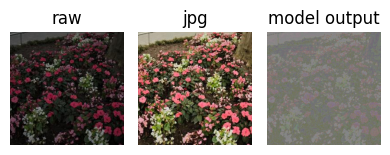

 20%|████████████████                                                                | 100/500 [04:51<18:39,  2.80s/it]

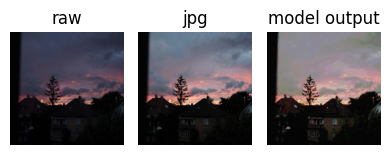

 25%|███████████████████▋                                                            | 123/500 [05:57<18:47,  2.99s/it]

In [ ]:
loss_summary = train_model(model, dataloader, optimizer, criterion, num_epochs)

In [ ]:
plt.plot(loss_summary)
# Add Title

plt.title("Average Loss of Episodes") 

# Add Axes Labels

plt.xlabel("Episodes") 
plt.ylabel("Loss") 

# Display

plt.show()

## Save Model

In [ ]:
def save_checkpoint(model, optimizer, directory, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    directory = f"models/{directory}"
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    torch.save(checkpoint, os.path.join(directory, filename))

In [ ]:
save_checkpoint(model, optimizer, directory=experiment, filename=model_name)

# Evaluation

### Performance on Training Images

In [ ]:
model.eval()
ungraded = ungraded.to(device)
edited_images, luts = model(ungraded)

In [ ]:
plot_image_grid(edited_images, "Edited Images")

### Is the generated LUT always the same?

In [ ]:
luts = []
for i in range(5):
    sample_input = torch.rand(1, 3, 64, 64).to(device)
    _, lut = model(sample_input)
    luts.append(lut)

In [ ]:
total_difference = sum(torch.sum(torch.abs(luts[i] - luts[j])) for i in range(len(luts)) for j in range(i + 1, len(luts)))

print(f"Total sum of differences: {total_difference}")

In [ ]:
_, lut0 = model(ungraded[0].unsqueeze(0))
_, lut30 = model(ungraded[30].unsqueeze(0))

In [ ]:
image30_lut0 = trilinear_interpolation(lut0, ungraded[30].unsqueeze(0))
image30_lut30 = trilinear_interpolation(lut30, ungraded[30].unsqueeze(0))
image0_lut30 = trilinear_interpolation(lut30, ungraded[0].unsqueeze(0))
image0_lut0 = trilinear_interpolation(lut0, ungraded[0].unsqueeze(0))

In [ ]:
def display_images(images):
    # Convert each tensor image to numpy and scale to [0, 255]
    images_np = []
    for image in images:
        tensor_image = image.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Convert to HWC format
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        images_np.append(image_np)
    
    # Concatenate images horizontally
    combined_image = np.concatenate(images_np, axis=1)
    
    # Create a PIL Image and display it
    combined_pil_image = Image.fromarray(combined_image)
    display(combined_pil_image)

In [ ]:
display_images([image30_lut0[0], image30_lut30[0]])

In [ ]:
display_images([image0_lut0[0], image0_lut30[0]])

# Save LUT

In [ ]:
def save_lut_from_model(model, sample_input, filename="trained_lut.cube", title="Generated LUT"):
    """
    Saves a 3D LUT generated by the model to a .cube file.
    
    Parameters:
        model (torch.nn.Module): Trained LUT generation model.
        sample_input (torch.Tensor): A sample input to generate the LUT. Shape: (B, C, H, W).
        filename (str): The output .cube file name.
        title (str): Title for the LUT.
    """
    import numpy as np
    import torch

    # Ensure model is in evaluation mode
    model.eval()

    # Generate the LUT
    with torch.no_grad():
        _, lut = model(sample_input)  # Forward pass
        lut_size = lut.shape[2]
        lut = lut.view(lut_size, lut_size, lut_size, 3)  # Reshape to (8, 8, 8, 3)

    # Ensure LUT is in numpy format
    lut = lut.detach().cpu().numpy()

    # Save the LUT to .cube
    with open(filename, "w") as f:
        # Write the header
        f.write(f"TITLE \"{title}\"\n")
        f.write(f"LUT_3D_SIZE {lut_size}\n")
        f.write("\n")

        # Normalize LUT values to [0, 1]
        lut = np.clip(lut, 0, 1)

        # Write LUT values
        for z in range(lut_size):
            for y in range(lut_size):
                for x in range(lut_size):
                    r, g, b = lut[x, y, z]  # Cube indexing convention
                    f.write(f"{r:.8f} {g:.8f} {b:.8f}\n")

    print(f"LUT saved to {filename}")

In [ ]:
#sample_input = torch.rand(1, 3, 64, 64).to(device)
#save_lut_from_model(model, sample_input, filename="trained_lut.cube", title="Trained LUT")

# Test LUT

In [ ]:
def apply_lut_to_image_interpolation(image, lut, lut_size):
    """
    Applies the LUT to the image using trilinear interpolation for better quality.
    
    Args:
        image: PIL Image in RGB format
        lut: 3D LUT array of shape (lut_size, lut_size, lut_size, 3)
        lut_size: Size of the LUT cube
    """
    # Convert image to RGB numpy array
    image = image.convert("RGB")
    image_data = np.array(image).astype(np.float32) / 255.0
    
    # Scale factors for the LUT
    scale = (lut_size - 1)
    scaled_data = image_data * scale
    
    # Get the floor and ceil indices for interpolation
    floor_idx = np.floor(scaled_data).astype(int)
    ceil_idx = np.minimum(floor_idx + 1, lut_size - 1)
    
    # Calculate interpolation weights
    alpha = scaled_data - floor_idx
    
    # Get the 8 neighboring points in the LUT
    c000 = lut[floor_idx[..., 0], floor_idx[..., 1], floor_idx[..., 2]]
    c001 = lut[floor_idx[..., 0], floor_idx[..., 1], ceil_idx[..., 2]]
    c010 = lut[floor_idx[..., 0], ceil_idx[..., 1], floor_idx[..., 2]]
    c011 = lut[floor_idx[..., 0], ceil_idx[..., 1], ceil_idx[..., 2]]
    c100 = lut[ceil_idx[..., 0], floor_idx[..., 1], floor_idx[..., 2]]
    c101 = lut[ceil_idx[..., 0], floor_idx[..., 1], ceil_idx[..., 2]]
    c110 = lut[ceil_idx[..., 0], ceil_idx[..., 1], floor_idx[..., 2]]
    c111 = lut[ceil_idx[..., 0], ceil_idx[..., 1], ceil_idx[..., 2]]

    # Perform trilinear interpolation
    c00 = c000 * (1 - alpha[..., 2:]) + c001 * alpha[..., 2:]
    c01 = c010 * (1 - alpha[..., 2:]) + c011 * alpha[..., 2:]
    c10 = c100 * (1 - alpha[..., 2:]) + c101 * alpha[..., 2:]
    c11 = c110 * (1 - alpha[..., 2:]) + c111 * alpha[..., 2:]
    
    c0 = c00 * (1 - alpha[..., 1:2]) + c01 * alpha[..., 1:2]
    c1 = c10 * (1 - alpha[..., 1:2]) + c11 * alpha[..., 1:2]
    
    interpolated = c0 * (1 - alpha[..., 0:1]) + c1 * alpha[..., 0:1]
    
    # Convert back to uint8 with proper rounding
    output = np.clip(interpolated * 255.0, 0, 255)
    output = np.round(output).astype(np.uint8)
    
    return Image.fromarray(output)

In [ ]:
def apply_lut_to_image(image, lut, lut_size):
    """
    Applies the LUT to the image and returns the modified image.
    """
    # Convert the image to RGB (if not already in that format)
    image = image.convert("RGB")
    image_data = np.array(image)
    
    # Normalize the image data to [0, lut_size-1] for indexing
    image_data = np.clip(image_data / 255.0 * (lut_size - 1), 0, lut_size - 1).astype(int)
    
    # Apply LUT to the image
    r, g, b = image_data[..., 0], image_data[..., 1], image_data[..., 2]
    image_data = lut[r, g, b]
    
    # Clip the result back to [0, 255] and convert to uint8
    image_data = np.clip(image_data * 255, 0, 255).astype(np.uint8)
    
    # Convert back to a PIL image
    return Image.fromarray(image_data)

In [ ]:
def load_cube_lut(lut_path):
    """
    Loads a .cube LUT file and returns it as a 3D numpy array.
    """
    with open(lut_path, 'r') as file:
        lines = file.readlines()

    # Read the LUT size (usually a 3D grid, e.g., 33x33x33)
    lut_size = None
    for line in lines:
        if line.lower().startswith('lut_3d_size'):
            lut_size = int(line.split()[1])
            break
    
    if not lut_size:
        raise ValueError("LUT size not found in the .cube file.")
    
    # Parse LUT data (expecting RGB values)
    lut = []
    for line in lines:
        if line.startswith("0") or line.startswith("1"):
            # Parsing LUT values (RGB)
            values = list(map(float, line.split()))
            lut.append(values)
    
    # Convert to a numpy array
    lut = np.array(lut).reshape((lut_size, lut_size, lut_size, 3))
    return lut, lut_size

### Comparison of LUT vs Model

#### Visual Comparison

In [ ]:
image = Image.open('../../fuji_images/RAW/JPG/256x256/DSCF2582.JPG')
display(image)

In [ ]:
lut, lut_size = load_cube_lut("../../fuji_images/Fuji01.cube")

In [ ]:
tensor = torch.from_numpy(lut)
# Add a new dimension at the start
tensor_lut = tensor.unsqueeze(0).to(device) 

In [ ]:
sample_image = transform(image).unsqueeze(0)
sample_image = sample_image.to(device)

In [ ]:
tensor_lut.shape

In [ ]:
sample_image.shape

In [ ]:
edited_image_lut = trilinear_interpolation(tensor_lut, sample_image)

In [ ]:
edited_image_model, lut = model(sample_image)

In [ ]:
jpg_image = Image.open('../../fuji_images/JPG/256x256/DSCF2582.JPG')
jpg_image = transform(jpg_image)
jpg_image = jpg_image.to(device)

In [ ]:
display_images([edited_image_model[0], edited_image_lut[0],jpg_image])

#### Get all Images with LUT

In [ ]:
tensor_lut_batch = tensor_lut.repeat(64, 1, 1, 1, 1)

In [ ]:
edited_images_lut = trilinear_interpolation(tensor_lut_batch, ungraded)

In [ ]:
plot_image_grid(edited_images_lut, "Edited Images LUT")

#### Calculate MSE between target Images (Graded JPG) and the two sets of edited images (Model and calculated LUT)

In [ ]:
def calc_mse(images1, images2):
    mse = torch.mean((images1 - images2) ** 2)
    return mse

In [ ]:
mse_edited_lut = calc_mse(edited_images_lut, graded.to(device))

In [ ]:
mse_edited_model = calc_mse(edited_images, graded.to(device))

In [ ]:
print(mse_edited_lut)

In [ ]:
print(mse_edited_model)

In [ ]:
labels = ['MSE for calculated LUT', 'MSE for Model']
values = [mse_edited_lut.cpu().item(), mse_edited_model.cpu().item()]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Mean Squared Error')
plt.title('MSE between target Images (graded JPG) and the two sets of edited images (Model and calculated LUT)')

plt.show()

#### Performance on Validation Images
TODO: Get new validation Images!!

In [ ]:
def load_images_from_directory(directory_path, num_images=100):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        img = transform64(img)  # Apply the transformations
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

# Replace fake images with actual data from the directory
val_ungraded_images = load_images_from_directory('../../fuji_images/Validation/RAW/JPG/256x256', num_images=600)
val_graded_images = load_images_from_directory('../../fuji_images/Validation/JPG/256x256', num_images=600)

# Verify the shape of the tensors
print(val_ungraded_images.shape)
print(val_graded_images.shape) 

In [ ]:
val_ungraded_images_np = val_ungraded_images.numpy()
val_graded_images_np = val_graded_images.numpy()

val_dataset = PairedImageDataset(val_ungraded_images_np, val_graded_images_np, transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
val_ungraded, val_graded = next(iter(val_dataloader))

In [ ]:
plot_image_grid(val_ungraded, "Validation Ungraded Images (RAW)")

In [ ]:
plot_image_grid(val_graded, "Validation Target Images (JPG)")

In [ ]:
edited_images_lut = trilinear_interpolation(tensor_lut_batch, val_ungraded.to(device))

In [ ]:
plot_image_grid(edited_images_lut, "Edited Images with calculated LUT")

In [ ]:
edited_images_model, luts = model(val_ungraded.to(device))

In [ ]:
plot_image_grid(edited_images_lut, "Edited Images with Model")

In [ ]:
display_image(edited_images_model[17])

In [ ]:
display_image(edited_images_lut[17])

In [ ]:
mse_edited_lut = calc_mse(edited_images_lut, val_graded.to(device))
mse_edited_model = calc_mse(edited_images_model, val_graded.to(device))

labels = ['MSE for calculated LUT', 'MSE for Model']
values = [mse_edited_lut.cpu().item(), mse_edited_model.cpu().item()]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Mean Squared Error')
plt.title('MSE between target Images (graded JPG) and the two sets of edited images (Model and calculated LUT)')

plt.show()

#### Performance on Sony images

In [ ]:
class ValDataset(Dataset):
    def __init__(self, val_images, transform=None):
        self.val_images = val_images
        self.transform = transform

    def __len__(self):
        return len(self.val_images)

    def __getitem__(self, idx):
        val_image = self.val_images[idx]
        if self.transform:
            val_image = self.transform(val_image)
        return val_image

In [ ]:
def load_orig_images(directory, num_images):
    images = []
    files = os.listdir(directory)
    
    # Ensure only image files are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory, image_file)
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0)
        img = img.to(device)
        images.append(img)

    return images

In [ ]:
sony_images = load_orig_images('../../sony_images/Validation', num_images=64)

In [ ]:
sony_images_256 = load_images_from_directory('../../sony_images/Validation', num_images=64)

In [ ]:
sony_dataset = ValDataset(sony_images_256.numpy(), transform)
sony_dataloader = DataLoader(sony_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
sony_val_images = next(iter(sony_dataloader))
sony_val_images = sony_val_images.to(device)

In [ ]:
plot_image_grid(sony_val_images, "Sony Test Images")

In [ ]:
def save_image(image, output_dir, filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    img = Image.fromarray(image_np)
    img = img.convert('RGB')
    img.save(os.path.join(output_dir, filename))

In [ ]:
for i,sony_img in tqdm(enumerate(sony_images), total=len(sony_images)):
    test = trilinear_interpolation(tensor_lut, sony_img)
    save_image(test[0], "test_images", f"test_lut{i}.jpg")

In [ ]:
for i,sony_img in tqdm(enumerate(sony_images), total=len(sony_images)):
    test = trilinear_interpolation(model(sony_val_images[i].unsqueeze(0))[1], sony_img)
    save_image(test[0], "test_images", f"test_model{i}.jpg")

In [ ]:
edited_images_lut = trilinear_interpolation(tensor_lut_batch, sony_val_images.to(device))

In [ ]:
edited_images_model, luts = model(sony_val_images.to(device))

In [ ]:
plot_image_grid(edited_images_lut, "Edited Images with calculated LUT")

In [ ]:
plot_image_grid(edited_images_model, "Edited Images with Model")